## 地闪定位仪数据处理及绘图部分

以下脚本示例皆为论文当中的程序，除了注释了中文字体部分的内容之外，其余基本一致。所使用的微软雅黑字体也在数据文件夹中，下载后指定路径并且取消相关注释即可。

windows用户可以更改matplotlib设置设置文件，将微软雅黑字体设置为首选项即可。

In [9]:
## 导入所需要的库
import os
from datetime import datetime, timedelta

import numpy as np
from scipy import stats
import pandas as pd

from matplotlib import cm, colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties

import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature  
import cartopy.io.shapereader as shpreader

#font = FontProperties(fname='MicrosoftYaHei.ttf')

In [2]:
## 图形环境设置
sns.set_context("talk", font_scale=1.5)

In [3]:
## 计算指定网格内闪电次数及工具函数
# get_ticks   :  主要用于将 colorbar 的 ticklabels 设置为时间格式
# get_density :  计算给定网格点内闪电出现的次数
# hex_to_rgb  :  转换 hex 颜色为 rgb 或 rgba

def get_ticks(mappable, step):
    """get colorbar ticks of mappable
    
    Agrs:
    
        mappable:
        
        step:
    
    Return:
        ticks
    """
    
    ticks = [mappable.colorbar.vmin]
    t = step
    while ticks[-1] < mappable.colorbar.vmax:
        ticks.append(mappable.colorbar.vmin + t*3600*1e9)
        t += step
    ticks[-1] = mappable.colorbar.vmax
    
    return ticks  

def get_density(longitudes, latitudes, binx, biny):
    """ 计算给定网格中经纬度数据出现的次数
    """
    
    return stats.binned_statistic_2d(longitudes, latitudes, None, 'count', bins=[binx, biny])

def hex_to_rgb(hexs, rgba=False):
    """convert hex to rgb or rgba
    
    parameters:
        hexs  : hexs color array.  list or np.array
        rgba  : control whether convert rgba.  logical
    """
    rgbs = []
    for h in hexs:
        rgb = [int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
        rgbs.append(rgb)

    if rgba:
        return colors.to_rgba_array(np.array(rgbs)/255)
    else:
        return np.array(rgbs)/255
    
def rgb_to_hex_array(rgbs):
    """convert rgb array to hex array
    
    parameters:
        rgbs : rgb color array
        
    """
    hexs = []
    for rgb in rgbs:
        hexs.append(colors.to_hex(rgb))
        
    return np.array(hexs)
    
def circle(x, y, radius=0.15, zorder=None, facecolor=None):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    
    circle = Circle((x, y), radius, clip_on=True, zorder=zorder, linewidth=1,
                    edgecolor='black', facecolor=facecolor,
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    ax.add_artist(circle)
    
def getflash(data, lon=None, lat=None, resample=None, factor=None, time_range=None, tdelta=None):
    """处理闪电数据
    
    参数：
        data     : 闪电数据. pandas.DataFrame  
        lon      : X方向的范围，用来筛选闪电.   list with two integer
        lat      : Y方向的范围，用来筛选闪电.   list with two integer
        resample : 对数据进行重采样,一般是对时间进行重采样. 比如每5分钟进行计数，统计5分钟内闪电次数. str
                    默认值为: "5min"，表示统计5分钟内闪电次数
        factor   : 和 resample 的值要一致，如果resample 是5min重采样一次，那么 factor = 5.  integer
      time_range :
        tdelta   : 时间偏差
        
     返回：
         data : 处理后的闪电数据
    """
    
    if tdelta is not None:
        data.index = data.index + tdelta
    data["cg"] = 1   
    
    data["pos"] = 0
    data.loc[data["intensity"] > 0, "pos"] = 1
    data["neg"] = 0
    data.loc[data["intensity"] < 0, "neg"] = 1  


    if lon:
        xindx = data.lon.between(lon[0], lon[1])
        data = data[xindx]
    if lat:   
        yindx = data.lat.between(lat[0], lat[1])
        data = data[yindx]        

    if resample:
        data = data.resample(resample).sum()
    else:
        resample = "5min"
        factor = 5
        data = data.resample(resample).sum()
        
    if factor:
        return data[["cg", "pos", "neg"]]/factor   
    else:
        return data[["cg", "pos", "neg"]] 

## 数据处理部分

In [4]:
## 处理闪电数据

data = pd.read_csv("/Users/yanglee/Documents/毕业论文/个例数据/20160623.txt", 
                   infer_datetime_format=True, 
#                   usecols=np.arange(1, 9)
                   sep=r"\s+", 
                   encoding="utf-8",
                   skiprows=0,
                   names=["num", "date", "time", "lat", "lon", "intensity", "slope", "error", "style", "pro", "city", "county"])

try:
    data[["lat", "lon", "intensity", "slope", "error"]] = data[["lat", "lon", "intensity", "slope", "error"]].applymap(lambda x: x.split("=")[1])
    data[["lat", "lon", "intensity", "slope", "error"]] = data[["lat", "lon", "intensity", "slope", "error"]].astype(np.float)
    data[["style", "pro", "city", "county"]] = data[["style", "pro", "city", "county"]].applymap(lambda x: x.split(":")[1])
except IndexError as e:
    print(e)
    raise IndexError("Count error when split string! Please check out!")

data.index = pd.to_datetime(data.date.map(str) + " " + data.time, format="%Y%m%d %H:%M:%S.%f")

#data.index = pd.to_datetime(data.date.map(str) + " " + data.time, format="%Y%m%d %H:%M:%S.%f")
data = data[["lat", "lon", "intensity", "slope", "error", "style"]]

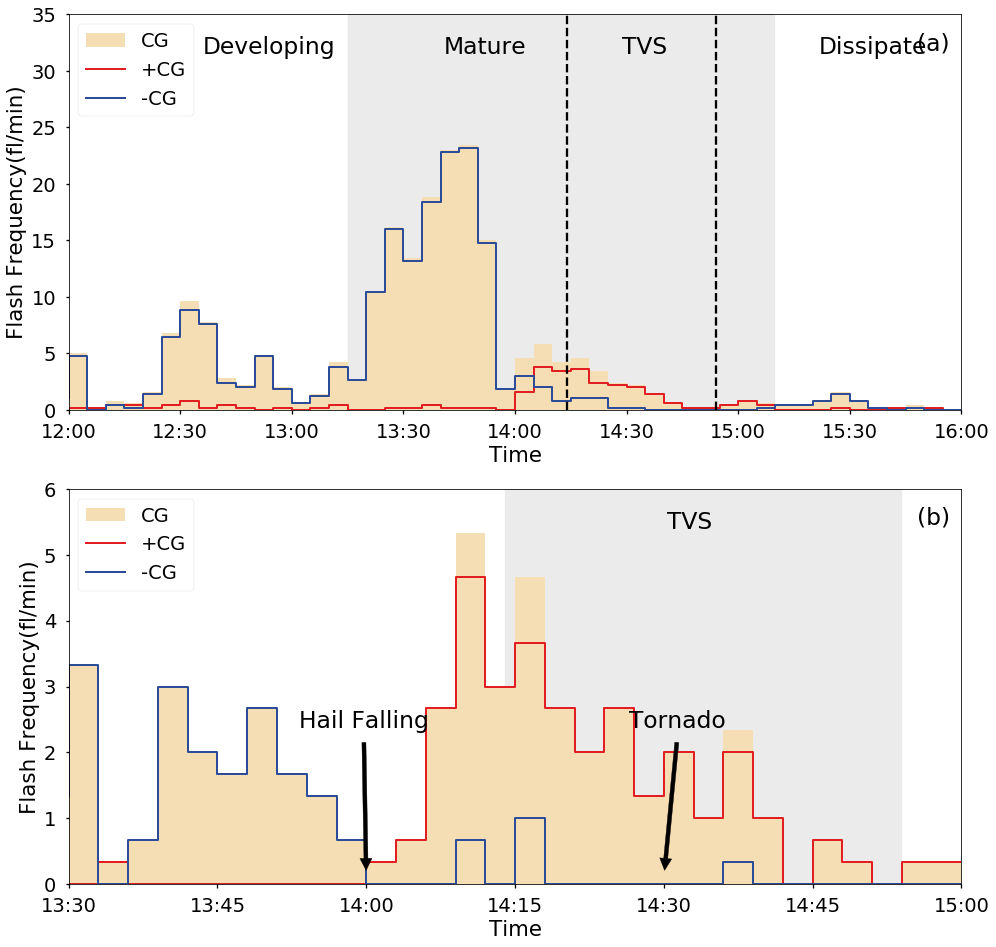

In [8]:
ft = 18

#font.set_size(ft)

lons = 118.5
lone = 120.5
lats = 33.5
late = 34.

ymin = 0
ymax = 35

blue = np.array([44, 75, 152])/255
red = np.array([226, 30, 34])/255

cgs = getflash(data, lon=[lons, lone], lat=[lats, late], resample="5min", factor=5)
cg = cgs["2016-06-23 12:00:00":"2016-06-23 16:00:00"]

xdates = pd.date_range(datetime(2016, 6, 23 ,12, 0, 0), datetime(2016, 6, 23, 16, 0, 0), freq="30min")

dates = cg.index.to_pydatetime()
edges = np.arange(cg.index.shape[0])

fig, ax = plt.subplots(figsize=[16, 16], ncols=1, nrows=2)

for i, j in enumerate(cg.cg.values):
    if i == 0:
        continue
    fb = ax[0].fill_between([dates[i-1], dates[i]], 0, j, facecolor="wheat") 

stp1 = ax[0].step(dates, cg.pos.values, linewidth=2, color=red)

stp2 = ax[0].step(dates, cg.neg.values, linewidth=2, color=blue)
#ax.step(edges, cg.cg.values, linewidth=2, color="black")       

#ax.set_xlim([0, edges.shape[0]])
ax[0].set_xlim([datetime(2016, 6, 23, 12, 0, 0), datetime(2016, 6, 23, 16, 0, 0)])
ax[0].set_ylim([ymin, ymax])

xdate = np.array([date.strftime("%H:%M") for date in xdates])

ax[0].set_xticks(xdates)
ax[0].set_xticklabels(xdate)

ax[0].set_xlabel("Time", )#fontproperties=font)
ax[0].set_ylabel("Flash Frequency(fl/min)",) #fontproperties=font)

## 成熟阶段填充
ax[0].fill_between([datetime(2016, 6, 23, 13, 15, 0), datetime(2016, 6, 23, 15, 10, 0)], 
                   ymin, ymax, 
                   color="0.9", alpha=0.8,
                  zorder=-1)

## TVS 分割线
ax[0].axvline(datetime(2016, 6, 23, 14, 14, 0), ymin, ymax, color="black", linestyle="--")
ax[0].axvline(datetime(2016, 6, 23, 14, 54, 0), ymin, ymax, color="black", linestyle="--")

## 超级单体发展阶段标注
ax[0].text(0.15, 0.9, "Developing", transform=ax[0].transAxes)#, fontproperties=font)
ax[0].text(0.42, 0.9, "Mature", transform=ax[0].transAxes)#, fontproperties=font)
ax[0].text(0.62, 0.9, "TVS", transform=ax[0].transAxes)#, fontproperties=font)
ax[0].text(0.84, 0.9, "Dissipate", transform=ax[0].transAxes)#, fontproperties=font)

ax[0].legend([fb, stp1[0], stp2[0]], 
             ["CG", "+CG", "-CG"], 
             fancybox=True,
             loc="upper left"
            )

ax[0].text(0.95, 0.91, "(a)", transform=ax[0].transAxes)

## TVS 阶段闪电变化
tvscgs = getflash(data, lon=[119.5, 120.1], lat=[33.39, 33.99], resample="3min", factor=3)
tvscg = tvscgs["2016-06-23 13:30:00":"2016-06-23 15:00:00"]

tvsdate = tvscg.index.to_pydatetime()

tvsstp1 = ax[1].step(tvsdate, tvscg.pos.values, linewidth=2, color=red)
tvsstp2 = ax[1].step(tvsdate, tvscg.neg.values, linewidth=2, color=blue)

for i, jj in enumerate(tvscg.cg.values):
    if i == 0:
        continue
    tvsfb = ax[1].fill_between([tvsdate[i-1], tvsdate[i]], 0, jj, facecolor="wheat") 
    
ax[1].set_xlim([datetime(2016, 6, 23, 13, 30, 0), datetime(2016, 6, 23, 15, 0, 0)])
ax[1].set_ylim([ymin, 6])

tvsxdates = pd.date_range(datetime(2016, 6, 23, 13, 30, 0), datetime(2016, 6, 23, 15, 0, 0), freq="15min")
tvsxdate = np.array([date.strftime("%H:%M") for date in tvsxdates])

#ax.set_xticks(np.arange(0, edges.shape[0], 15))
ax[1].set_xticks(tvsxdates)
ax[1].set_xticklabels(tvsxdate)

ax[1].set_yticks(np.arange(0, 7, 1))
ax[1].set_yticklabels(np.arange(0, 7, 1))

ax[1].text(0.95, 0.91, "(b)", transform=ax[1].transAxes)

ax[1].set_xlabel("Time") #, fontproperties=font)
ax[1].set_ylabel("Flash Frequency(fl/min)")#, fontproperties=font)

ax[1].fill_between([datetime(2016, 6, 23, 14, 14, 0), datetime(2016, 6, 23, 14, 54, 0)], 
                   0, 12, 
                   color="0.9", alpha=0.8,
                  zorder=-1)
#ax[1].axvline(datetime(2016, 6, 23, 14, 14, 0), ymin, ymax, color="orange", linestyle="--")
#ax[1].axvline(datetime(2016, 6, 23, 14, 54, 0), ymin, ymax, color="orange", linestyle="--")
ax[1].text(0.67, 0.9, "TVS", transform=ax[1].transAxes)

ax[1].legend([tvsfb, tvsstp1[0], tvsstp2[0]], 
             ["CG", "+CG", "-CG"], 
             fancybox=True,
             loc="upper left"
            )

ax[1].annotate("Hail Falling",
    xy=(datetime(2016, 6, 23, 14, 0, 0), 0.1), 
    xytext=(0.365, 0.25),
    textcoords="figure fraction",
    arrowprops=dict(facecolor="black", shrink=0.05, edgecolor="black"),
    horizontalalignment="center",
    verticalalignment="top",
#    fontproperties=font,
#            fontsize=30,
    color="black")

ax[1].annotate("Tornado",
    xy=(datetime(2016, 6, 23, 14, 30, 0), 0.1), 
    xytext=(0.68, 0.25),
    textcoords="figure fraction",
    arrowprops=dict(facecolor="black", shrink=0.05, edgecolor="black"),
    horizontalalignment="center",
    verticalalignment="top",
#    fontproperties=font,
#            fontsize=30,
    color="black")

if 0:
    plt.savefig("20160623_观测地闪时间序列.pdf",
               dpi=600,
               bbox_inches="tight")
    
plt.show()    

上述示例是论文中使用到的图形，下面给出另一种图形的绘制示例，即闪电随时间的空间演变

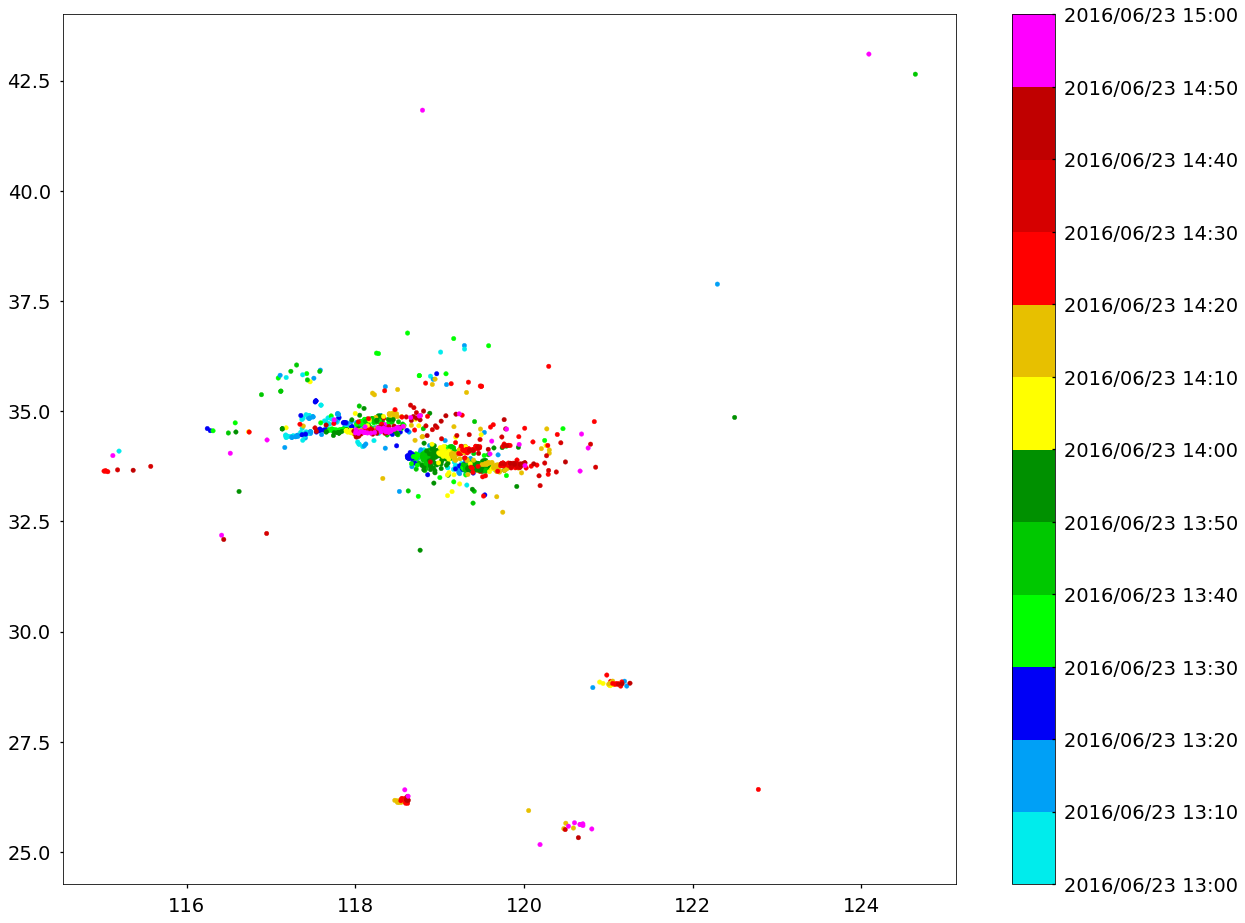

In [12]:
colev = ["#00ECEC", "#00A0F6", "#0000F6", 
         "#00FF00", "#00C800", "#009000", "#FFFF00", 
         "#E7C000", "#FF0000", "#D60000", "#C00000",
         "#FF00FF"]

cmaps = colors.ListedColormap(colev, 'indexed')   

plt.figure(figsize=(20, 16))
ss = data["2016-06-23 13:00:00":"2016-06-23 15:00:00"]
sct = plt.scatter(x=ss.lon.values, 
                  y=ss.lat.values,
                  s=20, 
                  c=ss.index-timedelta(hours=8),
                  vmin=datetime.timestamp(datetime(2016, 6, 23, 13, 0, 0))*1e9,
                  vmax=datetime.timestamp(datetime(2016, 6, 23, 15, 0, 0))*1e9,
                  cmap=cmaps)

cbar = plt.colorbar(sct)

step = 1/6  # 10/60 == 10 min  

ticks = get_ticks(sct, step)

cbar.set_ticks(ticks)
# 减 8*3600 是为了转换为北京时间

## 通过更改时间格式 %Y/%m/%d %H:%M  可以调整 colorbar 的时间显示方式
cbar.set_ticklabels([mdates.datetime.datetime.fromtimestamp(t/1e9).strftime('%Y/%m/%d %H:%M') for t in cbar.get_ticks()])
cbar.ax.tick_params(direction = "in")

#plt.xlim([115.5, 117.5])
#plt.ylim([34, 35])

plt.show()

再给出一个绘制空间密度分布的示例

In [21]:
# 网格精度，单位是度，step = 0.1 表示，网格大小为0.1度 X 0.1度
step = 0.1

den = get_density(data.lon, data.lat, np.arange(116, 121, step), np.arange(30, 38, step))

flash = den.statistic
flash[flash==0] = np.nan

lon, lat = np.meshgrid(np.arange(116+step/2, 121-step/2, step), np.arange(30+step/2, 38-step/2, step))

In [22]:
flclevs = np.array(['#d53e4f', '#f46d43', '#fdae61', 
           '#fee08b', '#ffffbf', '#e6f598', 
           '#abdda4', '#66c2a5', '#3288bd'
          ])


colev = ["#FFFFFF", "#EFEFEF", "#CFCFCF", "#AFAFAF", "#8F8F8F", 
         "#6F6F6F", "#4F4F4F", "#2F2F2F", "#0F0F0F"]
    
flcmap = colors.ListedColormap(colev, 'indexed')  

levels = np.array([0, 1, 5, 10, 15, 20, 30, 40, 50, 60])
norm = colors.BoundaryNorm(levels, flcmap.N)  

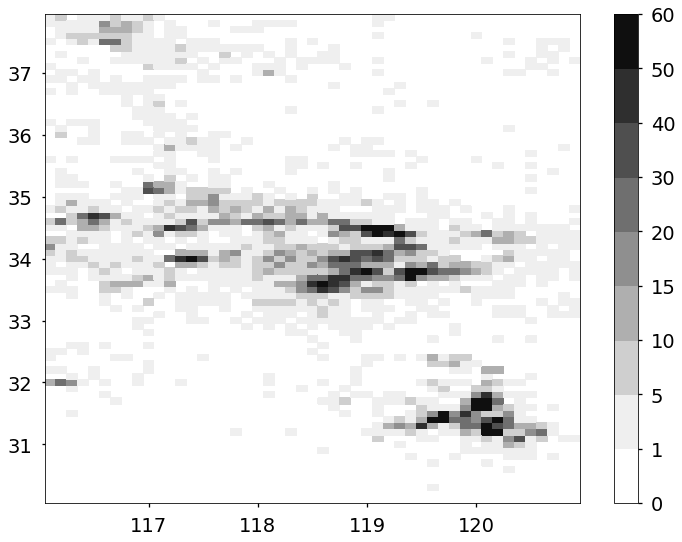

In [23]:
fig, ax = plt.subplots(figsize=(12, 9))

pm = ax.pcolormesh(lon.T, lat.T, flash, cmap=flcmap, norm=norm)

plt.colorbar(pm)
plt.show()